In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
students_count = 10000
students = pd.DataFrame({"student_id": np.arange(1, students_count + 1)})
students['weight'] = np.random.exponential(1, size=students_count) # a média de peso por estudante é 1, mas a maioria tem menos
students.head(3)

,student_id,weight
0,1,2.941121
1,2,0.429475
2,3,0.219936


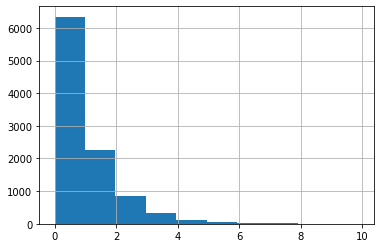

In [4]:
students['weight'].hist() # most students have low prob, a few ones have high probs

In [5]:
def generate_sessions_for_day(date, size, students):
  students_sample = students.sample(n=size, replace=True, weights='weight', ignore_index=True)
  today_sessions = pd.DataFrame({'date': np.full(size, date)})
  today_sessions = pd.concat([today_sessions, students_sample], axis=1)
  return today_sessions

## Declaring demand by day of the week 

In [138]:
# avg sessions by day as a percentage of students
# the avg by day will be the lambda parameter for the poisson distribution that generates the number of session for each day
avg_sessions_by_day = {                        
                        "Monday": 0.12,
                        "Tuesday": 0.13,
                        "Wednesday": 0.125,
                        "Thursday": 0.11,
                        "Friday": 0.07,
                        "Saturday": 0.02,
                        "Sunday": 0.05
                        }
avg_sessions_by_day
# int(students_count*0.05)

{'Monday': 0.12,
 'Tuesday': 0.13,
 'Wednesday': 0.125,
 'Thursday': 0.11,
 'Friday': 0.07,
 'Saturday': 0.02,
 'Sunday': 0.05}

In [140]:
def create_range(start_date, end_date):
  date_range = pd.DataFrame({'date': pd.date_range(start_date, end_date)})
  date_range['day_of_week'] = date_range['date'].dt.strftime('%A')
  perct_day = date_range['day_of_week'].map(avg_sessions_by_day)
  poisson_lambdas = [int(p * students_count) for p in perct_day]
  date_range['sessions_cnt'] = np.random.poisson(poisson_lambdas)
  return date_range

date_range = create_range('2022-10-01', '2022-10-07')
date_range

,date,day_of_week,sessions_cnt
0,2022-10-01,Saturday,182
1,2022-10-02,Sunday,503
2,2022-10-03,Monday,1157
3,2022-10-04,Tuesday,1300
4,2022-10-05,Wednesday,1242
5,2022-10-06,Thursday,1132
6,2022-10-07,Friday,712


## Generating empirical distribution for the session time

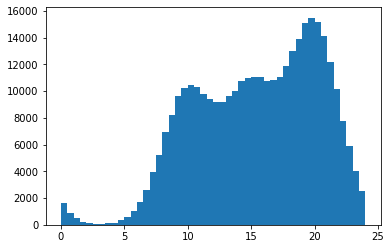

In [25]:
# creating a multi-modal distribution manually, with peaks at certain times
seed = 877
np.random.seed(seed)
peak_1 = np.random.normal(10, 2, 100000) # students who go to school in the evening (tutoring in the evening)
np.random.seed(seed)
peak_2 = np.random.normal(15, 2, 100000) # students who go to school in the morning (tutoring in the morning)
np.random.seed(seed)
peak_3 = np.random.normal(20, 2, 150000) # all students (tutoring at night)
multi_modal_dist = np.concatenate([peak_1, peak_2, peak_3])
multi_modal_dist = np.array([x-24 if x>=24 else 24+x if x<0 else x for x in multi_modal_dist])
plt.hist(multi_modal_dist, bins=48)
plt.show()

In [26]:
def ecdf(data):
  x = np.sort(data)
  y = np.arange(1, len(x)+1) / len(x) # transforms in fractions based on the position of each datapoint
  return x, y

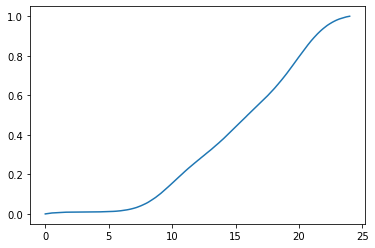

In [29]:
x, y = ecdf(multi_modal_dist)
plt.plot(x, y)
plt.show()

In [38]:
def sample_from_emp(x, y, size=10):
  rands = np.random.random(size)
  samples = [x[np.argmax(y>rand)] for rand in rands]
  return samples

def sample_session_times(size):
  return sample_from_emp(x, y, size)


In [42]:
sampled_times = sample_session_times(5000)

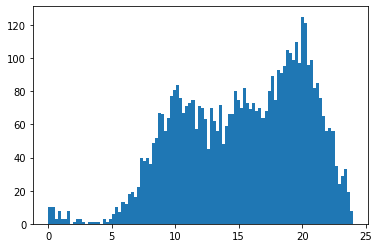

In [43]:
plt.hist(sampled_times, bins=100)
plt.show()

## Declaring Probabilities by subject

In [78]:
# demand is a number between 1-5 which represents the level of demand for a subject
subjects = pd.DataFrame({
                          'subject': ['Math', 'English', 'Biology', 'Chemistry'],
                          'demand':  [5, 4, 2, 3]                         
                         })
subjects

,subject,demand
0,Math,5
1,English,4
2,Biology,2
3,Chemistry,3


## Generating Tutors


In [207]:
tutors_count = 1000
tutors = pd.DataFrame({
                        'tutor_id': np.arange(1, tutors_count+1),
                        'status': np.full(tutors_count, 'Offline')
                       })
tutors['subject'] = subjects.sample(tutors_count, replace=True, weights='demand')['subject'].reset_index(drop=True)
tutors

,tutor_id,status,subject
0,1,Offline,English
1,2,Offline,Chemistry
2,3,Offline,English
3,4,Offline,English
4,5,Offline,Chemistry
...,...,...,...
995,996,Offline,Math
996,997,Offline,Chemistry
997,998,Offline,Math
998,999,Offline,Biology


In [208]:
# working hours
working_hours = pd.DataFrame({
                          'working_hours': ['00-08am', '08am-04pm', '04pm-00'],
                          'percent_tutors':  [0.05, 0.45, 0.5], 
                          'starts_at': ['00:00:00', '08:00:00', '16:00:00'],
                          'ends_at':   ['07:59:59', '15:59:59', '23:59:59']
                         })
working_hours

,working_hours,percent_tutors,starts_at,ends_at
0,00-08am,0.05,00:00:00,07:59:59
1,08am-04pm,0.45,08:00:00,15:59:59
2,04pm-00,0.50,16:00:00,23:59:59


In [209]:
sample_working_hours = working_hours.sample(tutors_count, replace=True, weights='percent_tutors')[['working_hours', 'starts_at', 'ends_at']].reset_index(drop=True)
tutors = pd.concat([tutors, sample_working_hours], axis=1)

In [210]:
tutors.groupby('working_hours')['subject'].value_counts(normalize=True)

working_hours  subject  
00-08am        Math         0.320755
               English      0.301887
               Chemistry    0.226415
               Biology      0.150943
04pm-00        Math         0.360248
               English      0.304348
               Chemistry    0.198758
               Biology      0.136646
08am-04pm      Math         0.364224
               English      0.269397
               Chemistry    0.219828
               Biology      0.146552
Name: subject, dtype: float64

In [211]:
days, weight = zip(*avg_sessions_by_day.items())
weight = [1/w for w in weight] # inverting the weight of the probability
weight_by_day = pd.DataFrame({'day': days, 'weight': weight})
weight_by_day
rests = weight_by_day.sample(tutors_count, replace=True, weights='weight')['day'].reset_index(drop=True)
rests.value_counts()

Saturday     447
Sunday       164
Friday       111
Monday        75
Wednesday     74
Tuesday       68
Thursday      61
Name: day, dtype: int64

In [212]:
tutors['rest_day'] = rests
tutors['active_sessions'] = 0
tutors

,tutor_id,status,subject,working_hours,starts_at,ends_at,rest_day,active_sessions
0,1,Offline,English,04pm-00,16:00:00,23:59:59,Friday,0
1,2,Offline,Chemistry,04pm-00,16:00:00,23:59:59,Tuesday,0
2,3,Offline,English,04pm-00,16:00:00,23:59:59,Thursday,0
3,4,Offline,English,04pm-00,16:00:00,23:59:59,Saturday,0
4,5,Offline,Chemistry,04pm-00,16:00:00,23:59:59,Saturday,0
...,...,...,...,...,...,...,...,...
995,996,Offline,Math,08am-04pm,08:00:00,15:59:59,Friday,0
996,997,Offline,Chemistry,08am-04pm,08:00:00,15:59:59,Friday,0
997,998,Offline,Math,04pm-00,16:00:00,23:59:59,Saturday,0
998,999,Offline,Biology,08am-04pm,08:00:00,15:59:59,Wednesday,0


In [101]:
currentDateAndTime = datetime.now()
currentDateAndTime
currentTime = currentDateAndTime.strftime("%H:%M:%S")
working_hours['ends_at'] > currentTime

0    False
1    False
2     True
Name: ends_at, dtype: bool

86400

## Processing Days in a Range

In [279]:
# generating a range
date_range = create_range('2022-10-10', '2022-10-24')

# generating sessions for a date range
sessions_range = pd.DataFrame()
for idx, row in date_range.iterrows():
  sessions_day = generate_sessions_for_day(row['date'], row['sessions_cnt'], students)
  sessions_day['hours'] = sample_session_times(row['sessions_cnt'])
  sessions_range = pd.concat([sessions_range, sessions_day], axis=0)

sessions_range

,date,student_id,weight,hours
0,2022-10-10,9457,1.634890,11.681381
1,2022-10-10,6384,1.633123,21.770659
2,2022-10-10,9412,6.192374,18.032935
3,2022-10-10,3233,2.711465,13.165740
4,2022-10-10,51,4.364026,21.902166
...,...,...,...,...
1220,2022-10-24,6015,1.658742,17.608932
1221,2022-10-24,2202,0.922608,15.158338
1222,2022-10-24,2367,0.693812,9.098605
1223,2022-10-24,4471,1.447649,11.282353


In [280]:
from datetime import datetime, timedelta
sessions_range['started_at'] = sessions_range.apply(lambda row: row['date'] + timedelta(hours=row['hours']), axis=1)
sessions_range['subject'] = subjects.sample(len(sessions_range), replace=True, weights='demand')['subject'].reset_index(drop=True)
sessions_range['duration_min'] = np.random.gamma(4, 4, size=len(sessions_range))
sessions_range['status'] = 'Queued'
sessions_range['tutor_id'] = None
sessions_range['finished_at'] = None
sessions_range.sort_values('started_at')

,date,student_id,weight,hours,started_at,subject,duration_min,status,tutor_id,finished_at
639,2022-10-10,9715,5.624639,0.003335,2022-10-10 00:00:12.006490,Chemistry,9.627295,Queued,None,None
1092,2022-10-10,8196,5.295175,0.049910,2022-10-10 00:02:59.676758,Chemistry,14.608577,Queued,None,None
879,2022-10-10,7766,2.100344,0.077543,2022-10-10 00:04:39.155105,English,6.913491,Queued,None,None
468,2022-10-10,7213,3.115876,0.220003,2022-10-10 00:13:12.011607,Chemistry,5.895729,Queued,None,None
531,2022-10-10,5407,2.840789,0.227290,2022-10-10 00:13:38.244077,Math,20.813884,Queued,None,None
...,...,...,...,...,...,...,...,...,...,...
697,2022-10-24,5023,1.564100,23.653724,2022-10-24 23:39:13.406974,English,17.936510,Queued,None,None
902,2022-10-24,6827,2.044093,23.672126,2022-10-24 23:40:19.651935,Math,27.442594,Queued,None,None
173,2022-10-24,1657,1.171772,23.704671,2022-10-24 23:42:16.817240,Chemistry,7.639022,Queued,None,None
211,2022-10-24,9859,1.049234,23.706601,2022-10-24 23:42:23.763864,Chemistry,9.613780,Queued,None,None


In [191]:
sessions_range['subject'].value_counts()

Math         4783
English      3866
Chemistry    2978
Biology      1940
Name: subject, dtype: int64

In [192]:
sessions_range['student_id'].value_counts()

5952    18
8515    16
1308    15
7642    14
8332    13
        ..
620      1
4601     1
1573     1
6097     1
211      1
Name: student_id, Length: 5698, dtype: int64

In [193]:
# investigating a specific student
sessions_range[sessions_range['student_id'] == 8083].sort_values('date')

,date,student_id,weight,hours,started_at,subject,duration_min,status,finished_at


## Processing tutor assignment for each session

In [281]:
sessions_range = sessions_range.sort_values('started_at').reset_index(drop=True)
sample = sessions_range.head()
sample

,date,student_id,weight,hours,started_at,subject,duration_min,status,tutor_id,finished_at
0,2022-10-10,9715,5.624639,0.003335,2022-10-10 00:00:12.006490,Chemistry,9.627295,Queued,None,None
1,2022-10-10,8196,5.295175,0.049910,2022-10-10 00:02:59.676758,Chemistry,14.608577,Queued,None,None
2,2022-10-10,7766,2.100344,0.077543,2022-10-10 00:04:39.155105,English,6.913491,Queued,None,None
3,2022-10-10,7213,3.115876,0.220003,2022-10-10 00:13:12.011607,Chemistry,5.895729,Queued,None,None
4,2022-10-10,5407,2.840789,0.227290,2022-10-10 00:13:38.244077,Math,20.813884,Queued,None,None


In [200]:
for idx, row in sample.iterrows():
  print("Processing Row:", row['student_id'])
  # check_finished
  check_finished_sessions(row['started_at'], sample)
  # check_tutors_status
  check_tutors_statuses(row['started_at'], tutors)
  # assign a tutor
  tutor_id = assign_a_tutor(row['subject'], tutors)
  sample.loc[idx, 'tutor_id'] = tutor_id

Processing Row: 8165
Sessions to finish: Int64Index([], dtype='int64')
Processing Row: 9921
Sessions to finish: Int64Index([], dtype='int64')
Processing Row: 6155
Sessions to finish: Int64Index([], dtype='int64')
Processing Row: 6080
Sessions to finish: Int64Index([], dtype='int64')
Processing Row: 1703
Sessions to finish: Int64Index([], dtype='int64')


In [180]:
sessions_range.query("subject == 'Math'")

,date,student_id,weight,hours,started_at,subject,duration_min,status
1,2022-10-10,9921,0.739020,0.045948,2022-10-10 00:02:45.412598,Math,16.422590,Queued
3,2022-10-10,6080,3.039250,0.118001,2022-10-10 00:07:04.803844,Math,29.347458,Queued
9,2022-10-10,5815,0.262327,1.435226,2022-10-10 01:26:06.814565,Math,27.886034,Queued
10,2022-10-10,1635,2.917289,2.356144,2022-10-10 02:21:22.116913,Math,26.009862,Queued
12,2022-10-10,9309,1.182709,5.144491,2022-10-10 05:08:40.167735,Math,6.178358,Queued
...,...,...,...,...,...,...,...,...
13555,2022-10-24,9823,2.250037,23.307860,2022-10-24 23:18:28.295809,Math,31.927153,Queued
13558,2022-10-24,3195,0.099519,23.383448,2022-10-24 23:23:00.414093,Math,24.976036,Queued
13559,2022-10-24,2398,2.328760,23.420114,2022-10-24 23:25:12.411422,Math,2.811387,Queued
13561,2022-10-24,1921,2.798811,23.530518,2022-10-24 23:31:49.866048,Math,4.877049,Queued


In [199]:
def check_finished_sessions(datetime_now, sessions, tutors):
  sessions_to_finish = sessions.query("status == 'Active' and finished_at < @datetime_now")
  print("Sessions to finish:", sessions_to_finish.index)
  sessions.loc[sessions_to_finish.index, 'status'] = 'Finished'
  # TODO: TODO: TODO: TODO: TODO: TODO: TODO: TODO: 
  # CONTINUAR DAQUI!!! PRA CADA sessions_to_finish, PRECISO DIMINUIR O ACTIVE_SESSIONS DO TUTOR!!!
  #tutor = 

In [234]:
def check_tutors_statuses(datetime_now, tutors):
  day_of_week = datetime_now.strftime('%A')
  currentTime = datetime_now.strftime("%H:%M:%S")
  tutors_to_block = tutors.query("status == 'Available' and @currentTime >= ends_at")
  print("Tutors to block", tutors_to_block.index)
  tutors.loc[tutors_to_block.index, 'status'] = 'Leaving'
  tutors_to_sign_off = tutors.query("status != 'Offline' and @currentTime >= ends_at and active_sessions == 0")
  print("Tutors to sing off", tutors_to_sign_off.index)
  tutors.loc[tutors_to_sign_off.index, 'status'] = 'Offline'
  tutors_to_activate = tutors.query("status != 'Available' and @currentTime >= starts_at and @currentTime <= ends_at and @day_of_week != rest_day")
  print("Tutors to activate", tutors_to_activate.index)
  tutors.loc[tutors_to_activate.index, 'status'] = 'Available'

In [278]:
def assign_a_tutor(subject, tutors):
  min_sessions_active = tutors.query("status == 'Available' and subject == @subject")['active_sessions'].min()
  tutors_min = tutors.query("status == 'Available' and subject == @subject and active_sessions == @min_sessions_active")
  print("min_sessions_active: ", min_sessions_active)
  tutor = tutors_min.sample()
  tutors.loc[tutor.index, 'active_sessions'] = min_sessions_active + 1
  return tutors.loc[tutor.index,'tutor_id'].values[0]



In [270]:
agora = datetime.now()
check_tutors_statuses(agora, tutors)
tutor = assign_a_tutor('Biology', tutors)
print(tutor)
tutors.query("status == 'Available' and subject == 'Biology'")

Tutors to block Int64Index([], dtype='int64')
Tutors to sing off Int64Index([], dtype='int64')
Tutors to activate Int64Index([], dtype='int64')
min_sessions_active:  2
248    249
Name: tutor_id, dtype: int64


,tutor_id,status,subject,working_hours,starts_at,ends_at,rest_day,active_sessions
36,37,Available,Biology,00-08am,00:00:00,07:59:59,Sunday,2
42,43,Available,Biology,00-08am,00:00:00,07:59:59,Tuesday,2
123,124,Available,Biology,00-08am,00:00:00,07:59:59,Saturday,2
164,165,Available,Biology,00-08am,00:00:00,07:59:59,Saturday,2
248,249,Available,Biology,00-08am,00:00:00,07:59:59,Saturday,3
385,386,Available,Biology,00-08am,00:00:00,07:59:59,Saturday,2
393,394,Available,Biology,00-08am,00:00:00,07:59:59,Saturday,3
405,406,Available,Biology,00-08am,00:00:00,07:59:59,Wednesday,2


In [277]:
tutor.

249

,tutor_id,status,subject,working_hours,starts_at,ends_at,rest_day,active_sessions
36,37,Available,Biology,00-08am,00:00:00,07:59:59,Sunday,1
42,43,Available,Biology,00-08am,00:00:00,07:59:59,Tuesday,1
123,124,Available,Biology,00-08am,00:00:00,07:59:59,Saturday,0
164,165,Available,Biology,00-08am,00:00:00,07:59:59,Saturday,0
248,249,Available,Biology,00-08am,00:00:00,07:59:59,Saturday,1
385,386,Available,Biology,00-08am,00:00:00,07:59:59,Saturday,0
393,394,Available,Biology,00-08am,00:00:00,07:59:59,Saturday,0
405,406,Available,Biology,00-08am,00:00:00,07:59:59,Wednesday,0


In [231]:

print("AGORA: ", agora)
tutors_to_activate = check_tutors_statuses(agora, tutors)

AGORA:  2022-10-28 02:05:27.542924
Tutors to block Int64Index([], dtype='int64')
Tutors to sing off Int64Index([], dtype='int64')
Tutors to activate Int64Index([ 11,  23,  36,  42,  53,  71, 110, 123, 140, 148, 164, 169, 247,
            248, 263, 322, 340, 342, 360, 368, 376, 382, 385, 393, 405, 459,
            508, 520, 530, 538, 546, 560, 569, 571, 615, 627, 668, 704, 708,
            759, 761, 772, 791, 806, 816, 900, 936, 940, 988],
           dtype='int64')


In [229]:
#tutors.loc[tutors_to_activate.index, 'status'] = 'Offline'

In [213]:
tutors

,tutor_id,status,subject,working_hours,starts_at,ends_at,rest_day,active_sessions
0,1,Offline,English,04pm-00,16:00:00,23:59:59,Friday,0
1,2,Offline,Chemistry,04pm-00,16:00:00,23:59:59,Tuesday,0
2,3,Offline,English,04pm-00,16:00:00,23:59:59,Thursday,0
3,4,Offline,English,04pm-00,16:00:00,23:59:59,Saturday,0
4,5,Offline,Chemistry,04pm-00,16:00:00,23:59:59,Saturday,0
...,...,...,...,...,...,...,...,...
995,996,Offline,Math,08am-04pm,08:00:00,15:59:59,Friday,0
996,997,Offline,Chemistry,08am-04pm,08:00:00,15:59:59,Friday,0
997,998,Offline,Math,04pm-00,16:00:00,23:59:59,Saturday,0
998,999,Offline,Biology,08am-04pm,08:00:00,15:59:59,Wednesday,0


In [202]:
agora = datetime.now()
agora.strftime('%A')
# date_range['date'].dt.strftime('%A')

'Friday'

In [185]:
datetime = '2022-10-21'
sessions_range.query("subject == 'Math' and date == @datetime")

,date,student_id,weight,hours,started_at,subject,duration_min,status
11044,2022-10-21,2877,1.019212,0.056203,2022-10-21 00:03:22.331970,Math,14.721367,Queued
11045,2022-10-21,2796,3.395148,0.102376,2022-10-21 00:06:08.552042,Math,13.243498,Queued
11052,2022-10-21,157,0.303203,3.725999,2022-10-21 03:43:33.596060,Math,11.520442,Queued
11054,2022-10-21,8894,0.877885,5.507226,2022-10-21 05:30:26.014347,Math,4.438916,Queued
11055,2022-10-21,9241,3.664849,5.627618,2022-10-21 05:37:39.424327,Math,16.628481,Queued
...,...,...,...,...,...,...,...,...
11739,2022-10-21,5089,2.955178,23.196887,2022-10-21 23:11:48.791563,Math,7.915527,Queued
11740,2022-10-21,8436,1.329995,23.248552,2022-10-21 23:14:54.788885,Math,10.167477,Queued
11745,2022-10-21,7951,0.568061,23.775529,2022-10-21 23:46:31.903993,Math,13.107160,Queued
11746,2022-10-21,8774,1.762744,23.804132,2022-10-21 23:48:14.876242,Math,31.148230,Queued
